In [32]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [33]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [34]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [35]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(0,255,0),thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(255,0,0), thickness=1, circle_radius=1))                            
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,255,0),thickness=2, circle_radius=3),
                             mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(188,0,255),thickness=2, circle_radius=3),
                             mp_drawing.DrawingSpec(color=(124,26,159), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255,43,0),thickness=2, circle_radius=3),
                             mp_drawing.DrawingSpec(color=(161,37,37), thickness=2, circle_radius=2))

In [36]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic: 
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        draw_landmarks(image, results)

        cv2.imshow('ML Project', image)
        if(cv2.waitKey(10) & 0xFF == ord('p')):
            break
    cap.release()
    cv2.destroyAllWindows()

In [37]:
draw_landmarks(frame,results)

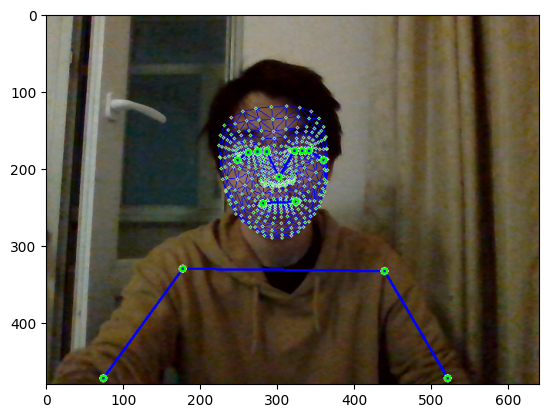

In [38]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [39]:
def extract_keypoints(results):
    pose = np.zeros(33*4)
    if results.pose_landmarks:
        pose=np.array([[res.x,res.y,res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
    
    lh = np.zeros(21*3)
    if results.left_hand_landmarks:
        lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten()
        
    rh=np.zeros(21*3)
    if results.right_hand_landmarks:
        rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten()
        
    face = np.zeros(468*3)
    if results.face_landmarks:
        face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten()
        
    return np.concatenate([pose, face, lh, rh])

In [40]:
extract_keypoints(results)[:-10]

array([ 0.4733066 ,  0.43969858, -1.31140542, ...,  0.        ,
        0.        ,  0.        ])

In [41]:
DATA_PATH = os.path.join('MP_Data')

actions = np.array(['hello', 'please', 'stop', 'done', 'sad'])

no_sequences = 30
sequence_length = 30

In [42]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except: 
            pass 

In [43]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic: 
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
    
                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                draw_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'starting collection', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'collecting frames for '+str(action)+' Video number '+ str(sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.waitKey(1000)
                else:
                    cv2.putText(image, 'collecting frames for '+str(action)+' Video number '+ str(sequence), (15,12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                    
                cv2.imshow('ML Project', image)
                if(cv2.waitKey(10) & 0xFF == ord('p')):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [44]:
cap.release()
cv2.destroyAllWindows()

In [45]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [46]:
label_map = {label: num for num, label in enumerate(actions)}

In [47]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [48]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [51]:
log_dir = os.path.join('LOGS')
tb_callback = TensorBoard(log_dir=log_dir)

In [52]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [54]:
model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [55]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
5/5 [==============================] - 3s 63ms/step - loss: 14.5269 - categorical_accuracy: 0.2746
Epoch 2/100
5/5 [==============================] - 0s 60ms/step - loss: 12.9380 - categorical_accuracy: 0.2042
Epoch 3/100
5/5 [==============================] - 0s 59ms/step - loss: 6.2023 - categorical_accuracy: 0.2042
Epoch 4/100
5/5 [==============================] - 0s 60ms/step - loss: 3.1477 - categorical_accuracy: 0.2254
Epoch 5/100
5/5 [==============================] - 0s 60ms/step - loss: 2.1026 - categorical_accuracy: 0.2113
Epoch 6/100
5/5 [==============================] - 0s 60ms/step - loss: 1.9979 - categorical_accuracy: 0.2535
Epoch 7/100
5/5 [==============================] - 0s 60ms/step - loss: 1.7879 - categorical_accuracy: 0.1620
Epoch 8/100
5/5 [==============================] - 0s 60ms/step - loss: 1.6688 - categorical_accuracy: 0.1127
Epoch 9/100
5/5 [==============================] - 0s 60ms/step - loss: 1.4824 - categorical_accuracy: 0.3099
Epoch 10

5/5 [==============================] - 0s 63ms/step - loss: 0.3227 - categorical_accuracy: 0.9296
Epoch 75/100
5/5 [==============================] - 0s 62ms/step - loss: 0.3609 - categorical_accuracy: 0.9085
Epoch 76/100
5/5 [==============================] - 0s 62ms/step - loss: 0.3051 - categorical_accuracy: 0.9437
Epoch 77/100
5/5 [==============================] - 0s 61ms/step - loss: 0.3012 - categorical_accuracy: 0.9155
Epoch 78/100
5/5 [==============================] - 0s 60ms/step - loss: 0.3154 - categorical_accuracy: 0.9155
Epoch 79/100
5/5 [==============================] - 0s 62ms/step - loss: 0.3018 - categorical_accuracy: 0.9014
Epoch 80/100
5/5 [==============================] - 0s 61ms/step - loss: 0.2928 - categorical_accuracy: 0.9225
Epoch 81/100
5/5 [==============================] - 0s 63ms/step - loss: 0.3118 - categorical_accuracy: 0.9155
Epoch 82/100
5/5 [==============================] - 0s 63ms/step - loss: 0.2360 - categorical_accuracy: 0.9577
Epoch 83/100
5

In [57]:
res = model.predict(X_test)

1/1 [==============================] - 0s 316ms/step


In [58]:
model.save('action.h5')

In [59]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [60]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 34ms/step


In [61]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [62]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 2],
        [0, 2]],

       [[6, 0],
        [2, 0]],

       [[6, 0],
        [0, 2]],

       [[6, 0],
        [0, 2]]], dtype=int64)

In [63]:
accuracy_score(ytrue, yhat)

0.75

In [64]:
sequence = []
sentence = []
threshold = .4

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic: 
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        
        draw_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence = (actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

        
        cv2.rectangle(image, (0, 0), (640, 40), (245, 300, 16), -1)
        cv2.putText(image, ''.join(sentence), (8,30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('ML Project', image)
        if(cv2.waitKey(10) & 0xFF == ord('p')):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step
